In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir
import requests
import io


import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

In [2]:
pd.options.display.max_columns = None

In [3]:
nodes_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-nodes.csv" 
edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-edges.csv"

In [4]:
# nodes_data = requests.get(nodes_url).content
# edges_data = requests.get(edges_url).content
# nodes = pd.read_csv(io.StringIO(nodes_data.decode('utf-8')))
# edges = pd.read_csv(io.StringIO(edges_data.decode('utf-8')))
nodes = pd.read_csv(nodes_url)
edges = pd.read_csv(edges_url)

In [5]:
omitted_organs = ['muscular_system', 'skeleton'] + ['lymph_vasculature', 'peripheral_nervous_system', 'blood_pelvis',] 
                                                    #'blood_vasculature']

blood_nodes = nodes[nodes['organ']=='blood_vasculature']
blood_edges = edges[edges['organ']=='blood_vasculature']

nodes = nodes[~nodes['organ'].isin(omitted_organs)]
edges = edges[~edges['organ'].isin(omitted_organs)]

In [6]:
edges

,organ,source,target,source_type,target_type
0,anatomical_systems,UBERON:0013702,UBERON:0000467,AS,AS
2,eye,UBERON:0013702,UBERON:0000970,AS,AS
3,kidney,UBERON:0013702,UBERON:0002113,AS,AS
4,knee,UBERON:0013702,UBERON:0001465,AS,AS
5,lung,UBERON:0013702,UBERON:0008886,AS,AS
...,...,...,...,...,...
16428,uterus,UBERON:0011949$$10391,ASCTB-TEMP:luminal-epithelial-cell$$10392,AS,CT
16429,uterus,UBERON:0002451$$10393,UBERON:0012276$$10394,AS,AS
16430,uterus,UBERON:0002451$$10393,UBERON:0011949$$10396,AS,AS
16431,uterus,UBERON:0012276$$10394,ASCTB-TEMP:glandular-epithelial-cell$$10395,AS,CT


In [7]:
edges['organ'].value_counts()

organ
blood_vasculature     4530
ovary                 2069
large_intestine       1332
allen_brain            867
uterus                 695
heart                  259
lung                   202
small_intestine        180
spleen                 178
pancreas               175
fallopian_tube         173
placenta               165
kidney                 157
lymph_node             128
spinal_cord            126
thymus                 105
eye                    103
anatomical_systems      87
skin                    73
palatine_tonsil         70
bone_marrow             49
liver                   47
trachea                 36
prostate                33
urinary_bladder         31
knee                    29
main_bronchus           25
ureter                  20
Name: count, dtype: int64

In [8]:
# nodes['name'] = nodes['name'].str.lower()

In [9]:
nodes

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702
1,UBERON:0000467,anatomical system,AS,anatomical_systems,UBERON:0000467
2,UBERON:0001009,circulatory system,AS,anatomical_systems,UBERON:0001009
3,UBERON:0004535,cardiovascular system,AS,anatomical_systems,UBERON:0004535
4,UBERON:0015410,heart plus pericardium,AS,anatomical_systems,UBERON:0015410
...,...,...,...,...,...
16429,UBERON:0002451$$10393,endometrial gland,AS,uterus,UBERON:0002451
16430,UBERON:0012276$$10394,endometrium glandular epithelium,AS,uterus,UBERON:0012276
16431,ASCTB-TEMP:glandular-epithelial-cell$$10395,glandular epithelial cell,CT,uterus,ASCTB-TEMP:glandular-epithelial-cell
16432,UBERON:0011949$$10396,endometrium luminal epithelium,AS,uterus,UBERON:0011949


In [10]:
nodes['organ'].value_counts()

organ
blood_vasculature     4533
ovary                 2069
large_intestine       1332
allen_brain            867
uterus                 695
heart                  256
lung                   202
small_intestine        180
spleen                 178
pancreas               175
fallopian_tube         173
placenta               165
kidney                 157
lymph_node             128
spinal_cord            126
thymus                 105
eye                    103
anatomical_systems      87
skin                    73
palatine_tonsil         70
bone_marrow             49
liver                   47
main_bronchus           33
prostate                33
urinary_bladder         31
knee                    29
trachea                 28
ureter                  20
body                     1
Name: count, dtype: int64

In [11]:
nodes.duplicated(subset=['id', 'type', 'organ', 'ontology_id']).sum()

0

In [12]:
nodes.duplicated(subset=['id'], keep=False).sum()

0

In [13]:
# nodes[nodes.duplicated(subset=['ontology_id', 'organ', 'type'], keep=False)].sort_values(by=['ontology_id', 'organ'])#.to_excel('duplicates_due_to_different_names_case_sensitive.xlsx')

In [14]:
def get_nodes(name=None, ontology_id=None):
    if name:
        return nodes[nodes['name'].str.lower()==name.lower()]
    if ontology_id:
        return nodes[nodes['ontology_id']==ontology_id]   

In [15]:
get_nodes(name='body')

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702


In [16]:
get_nodes(ontology_id='UBERON:0013702')

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702


In [55]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)

In [18]:
nx.is_tree(whole_graph)

True

In [19]:
len([com for com in nx.connected_components(whole_graph)])

1

In [20]:
connected_compontents = [com for com in nx.connected_components(whole_graph)]

In [21]:
get_nodes(ontology_id='UBERON:0002079')

,id,name,type,organ,ontology_id
88,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079


In [22]:
edges[edges['source']=='UBERON:0002079']

,organ,source,target,source_type,target_type
239,blood_vasculature,UBERON:0002079,CL:0010008,AS,CT
240,blood_vasculature,UBERON:0002079,FMA:49913,AS,AS
241,blood_vasculature,UBERON:0002079,FMA:49916,AS,AS
242,blood_vasculature,UBERON:0002079,UBERON:0002016,AS,AS
243,blood_vasculature,UBERON:0002079,FMA:49911,AS,AS
244,blood_vasculature,UBERON:0002079,FMA:49914,AS,AS
245,heart,UBERON:0002079,FMA:83532,AS,AS
246,heart,UBERON:0002079,FMA:83539,AS,AS
247,heart,UBERON:0002079,UBERON:0002049$$5394,AS,AS
248,heart,UBERON:0002079,UBERON:0001982$$5398,AS,AS


In [23]:
edges

,organ,source,target,source_type,target_type
0,anatomical_systems,UBERON:0013702,UBERON:0000467,AS,AS
2,eye,UBERON:0013702,UBERON:0000970,AS,AS
3,kidney,UBERON:0013702,UBERON:0002113,AS,AS
4,knee,UBERON:0013702,UBERON:0001465,AS,AS
5,lung,UBERON:0013702,UBERON:0008886,AS,AS
...,...,...,...,...,...
16428,uterus,UBERON:0011949$$10391,ASCTB-TEMP:luminal-epithelial-cell$$10392,AS,CT
16429,uterus,UBERON:0002451$$10393,UBERON:0012276$$10394,AS,AS
16430,uterus,UBERON:0002451$$10393,UBERON:0011949$$10396,AS,AS
16431,uterus,UBERON:0012276$$10394,ASCTB-TEMP:glandular-epithelial-cell$$10395,AS,CT


In [56]:
whole_graph_int = nx.convert_node_labels_to_integers(whole_graph, label_attribute='id')

In [57]:
graph_int_id_to_id = nx.get_node_attributes(whole_graph_int, 'id')

In [58]:
id_to_graph_int_id = {v: k for k, v in graph_int_id_to_id.items()}

In [59]:
id_to_graph_int_id['UBERON:0011949$$10396']

11942

In [94]:
nodes_int = nodes.copy()
nodes_int['graph_int_id'] = nodes_int['id'].map(id_to_graph_int_id)

In [60]:
blood_nodes_int = blood_nodes.copy()
blood_nodes_int['graph_int_id'] = blood_nodes_int['id'].map(id_to_graph_int_id)

In [61]:
blood_nodes_int

,id,name,type,organ,ontology_id,graph_int_id
88,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,26
89,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008,217
90,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913,218
91,CL:0000071,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071,229
92,CL:0002543,vein endothelial cell,CT,blood_vasculature,CL:0002543,230
...,...,...,...,...,...,...
4616,FMA:8619,Right posterior segmental artery,AS,blood_vasculature,FMA:8619,4772
4617,CL:0000071$$3471,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071,4787
4618,CL:1000413$$3472,endothelial cell of artery,CT,blood_vasculature,CL:1000413,4788
4619,CL:0000057$$3473,fibroblast,CT,blood_vasculature,CL:0000057,4789


In [62]:
blood_edges_int = blood_edges.copy()
blood_edges_int['source'] = blood_edges_int['source'].map(id_to_graph_int_id)
blood_edges_int['target'] = blood_edges_int['target'].map(id_to_graph_int_id)

In [63]:
blood_edges_int

,organ,source,target,source_type,target_type
26,blood_vasculature,24,26,AS,AS
27,blood_vasculature,24,27,AS,AS
28,blood_vasculature,24,28,AS,AS
29,blood_vasculature,24,29,AS,AS
239,blood_vasculature,26,217,AS,CT
...,...,...,...,...,...
4808,blood_vasculature,4778,4786,AS,CT
4809,blood_vasculature,4772,4787,AS,CT
4810,blood_vasculature,4772,4788,AS,CT
4811,blood_vasculature,4772,4789,AS,CT


In [64]:
blood_graph_int = nx.from_pandas_edgelist(blood_edges_int, source='source', target='target', edge_attr=True)

In [111]:
# from netgraph import Graph


# Graph(whole_graph, edge_layout='curved')
# plt.show()

In [39]:
layout_pos_full_neato = nx.drawing.nx_agraph.graphviz_layout(whole_graph_int)

In [73]:
layout_pos_full_twopi = nx.drawing.nx_agraph.graphviz_layout(whole_graph_int, prog='twopi')

In [77]:
get_nodes('heart')

,id,name,type,organ,ontology_id
5,UBERON:0000948,heart,AS,anatomical_systems,UBERON:0000948


In [78]:
id_to_graph_int_id['UBERON:0000948']

24

In [95]:
# those nodes whose ontology id is in both blood and whole graph but not in 'blood_vasculature' organ
nodes_except_blood = nodes_int[nodes_int['organ']!='blood_vasculature']

# matching nodes between blood vasculature and other organs
matching_nodes = nodes_except_blood[nodes_except_blood['ontology_id'].isin(blood_nodes_int['ontology_id'])]



In [96]:
len(matching_nodes)

453

In [98]:
matching_nodes['organ'].value_counts()

organ
large_intestine    228
heart               95
uterus              21
placenta            16
lymph_node          12
thymus              12
palatine_tonsil     12
spleen              11
kidney               8
small_intestine      8
lung                 7
fallopian_tube       5
liver                5
prostate             5
skin                 2
ovary                2
pancreas             1
eye                  1
main_bronchus        1
allen_brain          1
Name: count, dtype: int64

In [99]:
matching_nodes[matching_nodes['ontology_id'].duplicated(keep=False)]

,id,name,type,organ,ontology_id,graph_int_id
9293,CL:0000057$$5150,fibroblast,CT,allen_brain,CL:0000057,198
10132,CL:0000057$$5250,fibroblast,CT,fallopian_tube,CL:0000057,5781
10152,CL:0000057$$5258,fibroblast,CT,fallopian_tube,CL:0000057,5802
10172,CL:0000057$$5273,fibroblast,CT,fallopian_tube,CL:0000057,5823
10192,CL:0000057$$5288,fibroblast,CT,fallopian_tube,CL:0000057,5845
...,...,...,...,...,...,...
15808,UBERON:0015173$$9801,arcuate artery of uterus,AS,uterus,UBERON:0015173,11362
15811,UBERON:0015173$$9803,arcuate artery of uterus,AS,uterus,UBERON:0015173,11367
15814,UBERON:0015173$$9805,arcuate artery of uterus,AS,uterus,UBERON:0015173,11372
15817,UBERON:0015173$$9807,arcuate artery of uterus,AS,uterus,UBERON:0015173,11377


In [108]:
get_nodes('fibroblast')['organ'].value_counts()

organ
blood_vasculature    654
large_intestine       83
heart                 24
small_intestine        8
fallopian_tube         5
allen_brain            1
palatine_tonsil        1
pancreas               1
Name: count, dtype: int64

In [109]:
get_nodes('fibroblast')['id'].duplicated().sum()    

0

In [101]:
blood_edges[(blood_edges['source'].apply(lambda x: 'CL:0000057' in str(x)))|(blood_edges['target'].apply(lambda x: 'CL:0000057' in str(x)))]

,organ,source,target,source_type,target_type
300,blood_vasculature,UBERON:0000947,CL:0000057,AS,CT
305,blood_vasculature,UBERON:0001496,CL:0000057$$28,AS,CT
312,blood_vasculature,UBERON:0001508,CL:0000057$$32,AS,CT
322,blood_vasculature,UBERON:0001529,CL:0000057$$36,AS,CT
328,blood_vasculature,UBERON:0001531,CL:0000057$$40,AS,CT
...,...,...,...,...,...
4791,blood_vasculature,FMA:8616,CL:0000057$$3457,AS,CT
4797,blood_vasculature,ASCTB-TEMP:high-truncus-anterior-of-right-pulm...,CL:0000057$$3461,AS,CT
4803,blood_vasculature,FMA:8620,CL:0000057$$3465,AS,CT
4807,blood_vasculature,FMA:8617,CL:0000057$$3469,AS,CT


In [105]:
blood_edges[blood_edges['target'].apply(lambda x: 'CL:0000057' in str(x))]

,organ,source,target,source_type,target_type
300,blood_vasculature,UBERON:0000947,CL:0000057,AS,CT
305,blood_vasculature,UBERON:0001496,CL:0000057$$28,AS,CT
312,blood_vasculature,UBERON:0001508,CL:0000057$$32,AS,CT
322,blood_vasculature,UBERON:0001529,CL:0000057$$36,AS,CT
328,blood_vasculature,UBERON:0001531,CL:0000057$$40,AS,CT
...,...,...,...,...,...
4791,blood_vasculature,FMA:8616,CL:0000057$$3457,AS,CT
4797,blood_vasculature,ASCTB-TEMP:high-truncus-anterior-of-right-pulm...,CL:0000057$$3461,AS,CT
4803,blood_vasculature,FMA:8620,CL:0000057$$3465,AS,CT
4807,blood_vasculature,FMA:8617,CL:0000057$$3469,AS,CT


In [79]:
distance_from_heart = nx.shortest_path_length(whole_graph_int, source=24)

In [86]:
whole_graph_int_truncated = whole_graph_int.copy()
whole_graph_int_truncated.remove_nodes_from([node for node in whole_graph_int if distance_from_heart[node]>3])

blood_graph_int_truncated = blood_graph_int.copy()
blood_graph_int_truncated.remove_nodes_from([node for node in blood_graph_int if distance_from_heart[node]>3])

In [87]:
len(blood_graph_int_truncated)

64

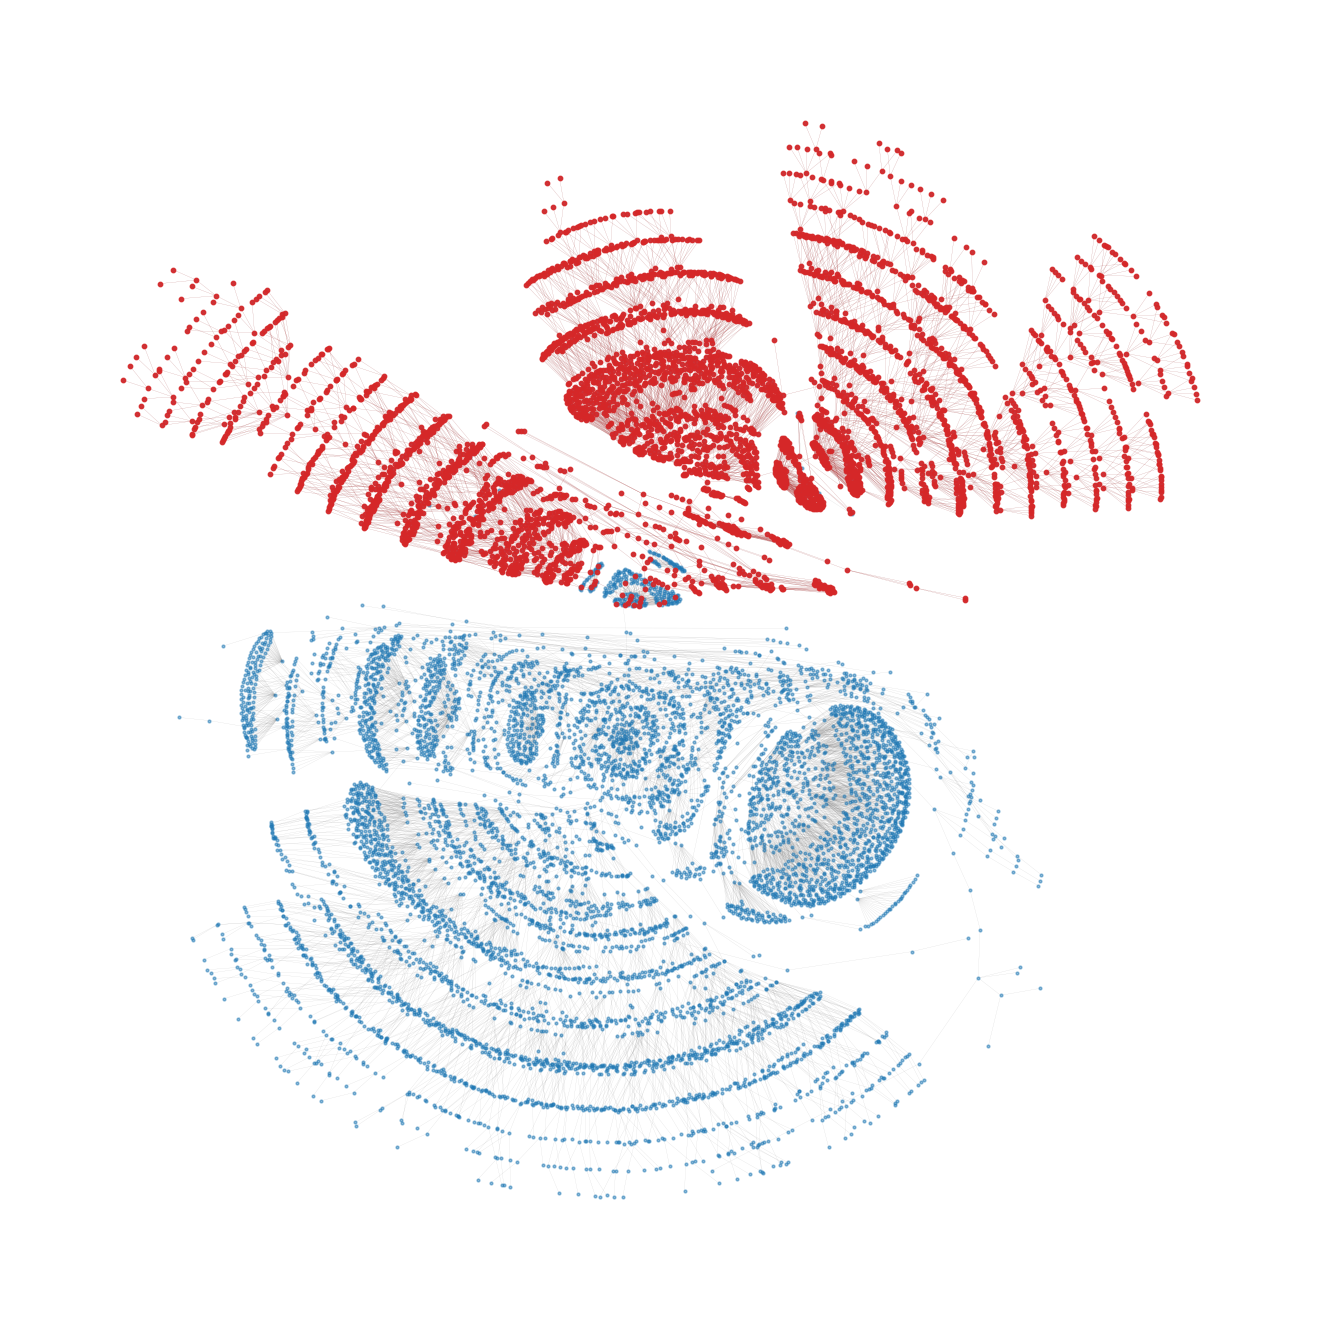

In [85]:
plt.figure(figsize=(13,13))
nx.draw(whole_graph_int, pos=layout_pos_full_neato, node_size=4, width=0.1, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(blood_graph_int, pos=layout_pos_full_neato, node_size=10, node_color='tab:red', alpha=.9)
nx.draw_networkx_edges(blood_graph_int, pos=layout_pos_full_neato, edge_color='tab:red', width=0.1, alpha=0.5)
# nx.draw_networkx_nodes(vasc_graph, layout_pos_full, 
#                        nodelist=matching_nodes_in_blood_vasc['id'].tolist(), 
#                        node_size=10, node_color='tab:orange', )
plt.show()

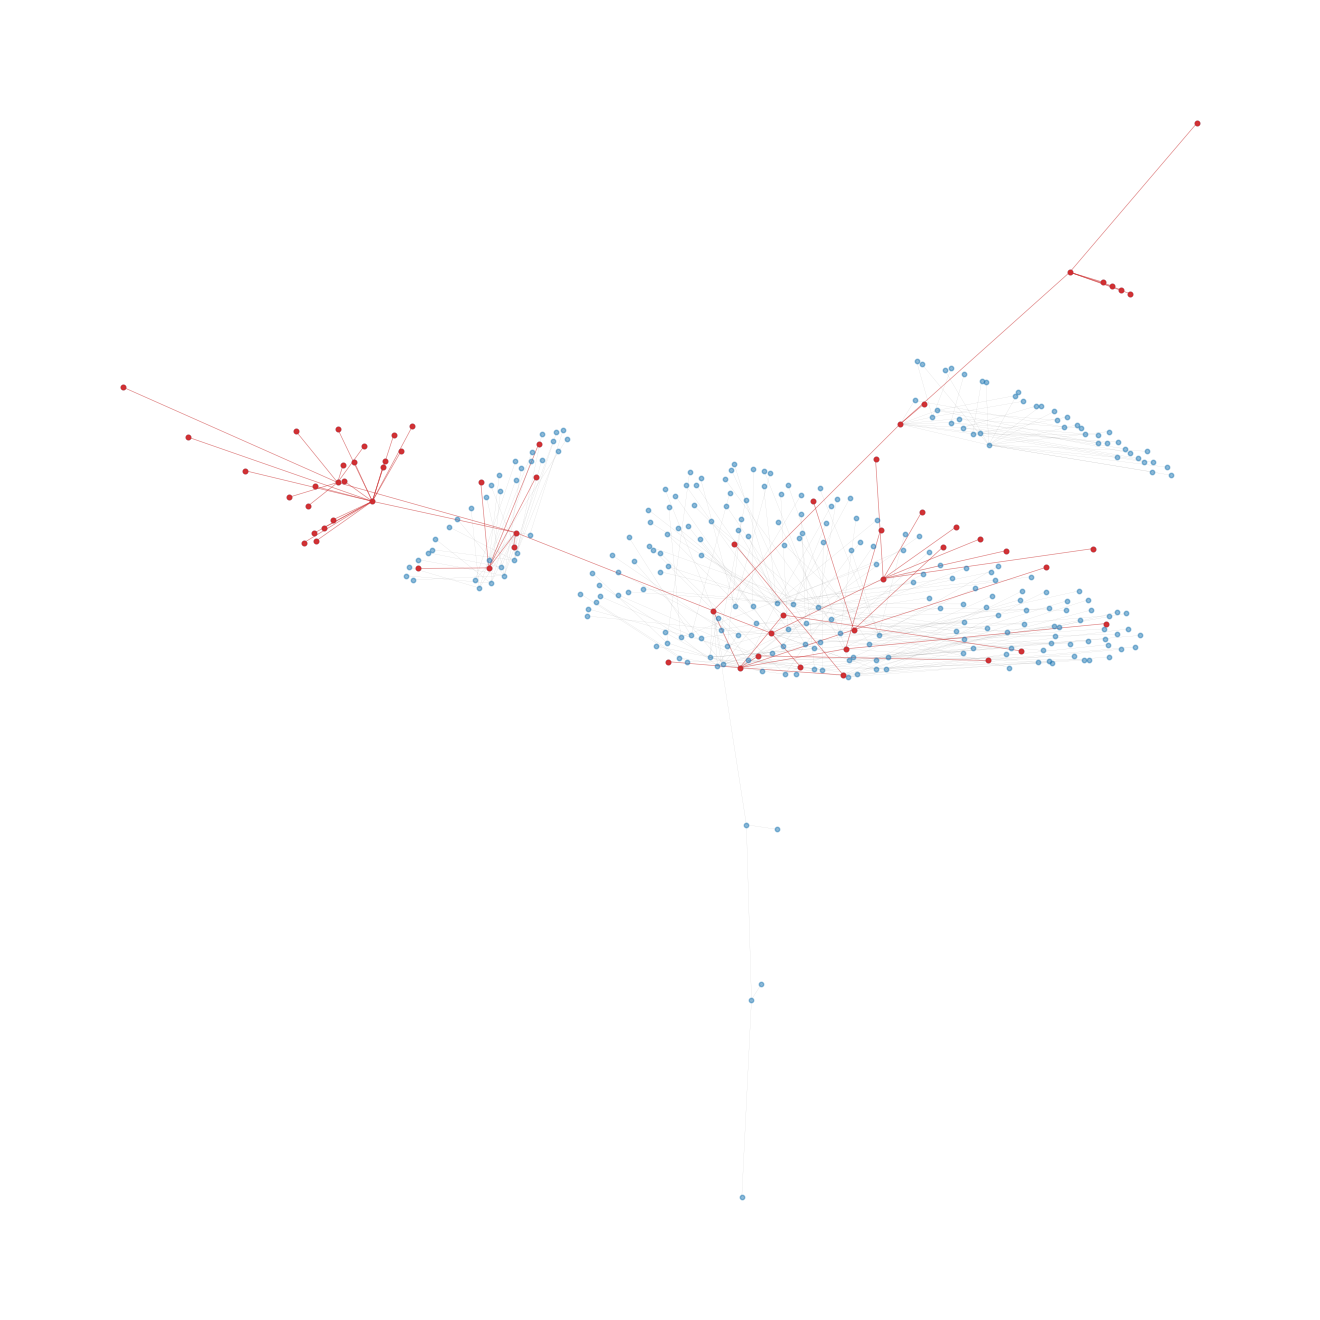

In [90]:
plt.figure(figsize=(13,13))
nx.draw(whole_graph_int_truncated, pos=layout_pos_full_neato, node_size=10, width=0.1, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(blood_graph_int_truncated, pos=layout_pos_full_neato, node_size=10, node_color='tab:red', alpha=.9)
nx.draw_networkx_edges(blood_graph_int_truncated, pos=layout_pos_full_neato, edge_color='tab:red', width=0.5, alpha=0.5)
# nx.draw_networkx_nodes(vasc_graph, layout_pos_full, 
#                        nodelist=matching_nodes_in_blood_vasc['id'].tolist(), 
#                        node_size=10, node_color='tab:orange', )
plt.show()

In [70]:
edges['organ'].nunique()

33

In [12]:
organ_order = ['bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee','large_intestine', 'liver', 'lung', 'lymph_node',
               'main_bronchus', 'trachea',  'spinal_cord', 'skin', 'thymus', 'spleen', 'pancreas', 'small_intestine', 'urinary_bladder', 
               'ureter', 'prostate', 'palatine_tonsil', 'ovary',  'uterus', 'placenta_full_term']

In [72]:
omitted_organs = ['muscular_system', 'skeleton']

# "muscular system, skeleton might be omitted—few CTs, Bs."

In [14]:
print('New organs:')
[organ for organ in json_data_asctb.keys() if organ not in organ_order+['blood', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']+omitted_organs]

New organs:


[]

In [15]:
json_data_asctb = {organ: json_data_asctb[organ] for organ in organ_order}

In [16]:
json_data_asctb.keys()

dict_keys(['bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_node', 'main_bronchus', 'trachea', 'spinal_cord', 'skin', 'thymus', 'spleen', 'pancreas', 'small_intestine', 'urinary_bladder', 'ureter', 'prostate', 'palatine_tonsil', 'ovary', 'uterus', 'placenta_full_term'])

In [17]:
def combine_data(json_dat, remove_ctct=True, combine=True, blood=False, verbose=False):
    """
    combine_data takes the json data of the organs and returns the node and edge lists in pandas dataframes

    :param json_dat: data of all the organs in a json format that was loaded by the load_data function
    :param remove_ctct: There should not be edges between CT and CT, however sometimes there can be mistakes in the data files. 
    :param combine: if true then the organs are combined into one network, and the function outputs 2 dataframes: nodes and edges. 
                    if false, then the organs are not combined, the function returns a node and an edge table for each organ.
    :param blood: By default it is false, and in this case, the function ignores the following tables: 'blood_pelvis', 'blood_vasculature', 
                 'lymph_vasculature', and 'peripheral_nervous_system'. If true, then 'blood_vasculature' is not excluded.

    """ 
    nodes_data = []
    edges_data = []
    organ_names = ['body']
    
    # The numbering of the nodes starts from 1 in each organ
    # If we combine the organs, we need a new id
    node_id_start_point = 1 
    
    #Add the 'body' node to the nodes data:
    body_df = pd.DataFrame(json_dat['brain']['nodes']).head(1)
    body_df.index = body_df['id']
    body_df['id_old'] = 0
    body_df['organ'] = 'body'
    body_df['ontology_id'] = 'UBERON:0013702'
    
    nodes_data += [body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]]

    organ_is_tree = {}
    
    if not combine:
        body_data = body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']].copy()
    
    if blood:
        exclude = ['blood_pelvis', 'lymph_vasculature', 'peripheral_nervous_system']
    else:
        exclude = ['blood_pelvis', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']
    
    for name in json_dat.keys():
        if name in exclude:
            continue
        else:
            # print(name)
            organ_names += [name]
            # Combine nodes:
            organ_nodes = pd.DataFrame(json_dat[name]['nodes']).iloc[1:,:]
            not_as_ct_nodes = organ_nodes[~organ_nodes['type'].isin(['AS', 'CT'])]['id'] #filter for AS and CT
            organ_nodes['id_old'] = organ_nodes['id'].copy()
            if combine:
                organ_nodes['id'] = organ_nodes['id'].add(node_id_start_point-1)
            organ_nodes.index = organ_nodes['id']
            # organ_nodes = organ_nodes.drop(columns=['id'])
            organ_nodes = organ_nodes[organ_nodes['type'].isin(['AS', 'CT'])]
            organ_nodes['organ'] = name
            organ_nodes['ontology_id'] = organ_nodes['metadata'].apply(lambda x: x['ontologyId'])
            organ_nodes = organ_nodes[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]
            

            # Combine edges:
            organ_edges = pd.DataFrame(json_dat[name]['edges'])
            ## Remove CT-CT edges:
            if remove_ctct:
                organ_nodes_original = pd.DataFrame(json_dat[name]['nodes'])
                organ_nodes_original.index = organ_nodes_original['id']
                organ_edges['source_type'] = organ_edges['source'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges['target_type'] = organ_edges['target'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges = organ_edges[(organ_edges['source_type']=='AS')|(organ_edges['target_type']=='AS')]
            ##rename edges due to colliding ids
            organ_network = nx.from_pandas_edgelist(organ_edges)
            #remove unnecessary edges:
            organ_network.remove_nodes_from(not_as_ct_nodes.to_list())
            # Remove body-organ edge (we will add it later)
            organ_network.remove_edge(0, 1)
            organ_network.remove_node(0)
            #rename nodes
            # organ_network = nx.relabel_nodes(organ_network, organ_nodes['name'].to_dict())
            if combine:
                organ_network = nx.convert_node_labels_to_integers(organ_network, first_label=node_id_start_point)
            #add body-organ edge
            # organ_network.add_node(0) 
            # nx.set_node_attributes(organ_network, {0: {"type": 'AS', "name": "Body", 'organ': 'body', 'ontology_id': 'UBERON:0013702'}})
            if combine:
                organ_network.add_edge(0, node_id_start_point) #add body-organ edge
                #v1.6 correction:
                if name=='lung':
                    organ_network.add_edge(node_id_start_point, 63+node_id_start_point-1)  #connect respiratory system to pulmonary vascular system  
                    organ_network.add_edge(node_id_start_point, 69+node_id_start_point-1)  #connect respiratory system to systemic artery
                    organ_network.add_edge(node_id_start_point, 73+node_id_start_point-1)  #connect respiratory system to venous blood vessel

                elif name=='trachea':
                    organ_network.add_edge(node_id_start_point, 15+node_id_start_point-1)  #connect trachea to bronchial vein
                    organ_network.add_edge(node_id_start_point, 18+node_id_start_point-1)  #connect trachea to bronchial artery
                    
                elif name=='main_bronchus':
                    organ_network.add_edge(node_id_start_point, 10+node_id_start_point-1) #connect extrapulmonary bronchus to bronchial artery
                    organ_network.add_edge(node_id_start_point, 13+node_id_start_point-1) #connect extrapulmonary bronchus to bronchial vein
                    
            else:
                organ_network.add_edge(0, 1) #add body-organ edge
                
                #v1.6 corrections:
                if name=="lung":
                    organ_network.add_edge(1, 63) #connect lung to pulmonary vascular system
                    organ_network.add_edge(1, 69) #connect lung to systemic artery
                    organ_network.add_edge(1, 73) #connect lung to venous blood vessel

                elif name=="trachea":
                    organ_network.add_edge(1, 15) #connect trachea to bronchial vein
                    organ_network.add_edge(1, 18) #connect trachea to bronchial artery

                elif name=='main_bronchus':
                    organ_network.add_edge(1, 10) #connect extrapulmonary bronchus to bronchial artery
                    organ_network.add_edge(1, 13) #connect extrapulmonary bronchus to bronchial vein


                

            # Create CT duplicates
            organ_CT_nodes = organ_nodes[organ_nodes['type']=='CT'].copy()
            organ_CT_nodes['degree'] = dict(organ_network.degree(organ_CT_nodes['id'])).values()
            
            ct_nodes_to_copy = organ_CT_nodes[organ_CT_nodes['degree']>1]['id'].values
            edges_to_remove = []
            edges_to_add = []
            
            for ct_node in ct_nodes_to_copy:
                as_neighbors_of_ct = list(nx.neighbors(organ_network, ct_node))
                for ind, as_neighbor in enumerate(as_neighbors_of_ct):
                    if ind==0:
                        continue
                    else:
                        ct_node_details = organ_nodes.loc[ct_node].to_dict()
                        new_node_id = organ_nodes['id'].max()+1
                        ct_node_details['id'] = new_node_id
                        # organ_nodes = organ_nodes.append(ct_node_details, ignore_index=False)
                        organ_nodes.loc[new_node_id] = ct_node_details
                        
                        edges_to_remove += [(as_neighbor, ct_node)]
                        edges_to_add += [(as_neighbor, new_node_id)]

            if verbose:
                print(name)
                print(f'Number of deleted edges: {len(edges_to_remove)}')
                print(f'Number of added edges: {len(edges_to_add)}')
                
            organ_network.remove_edges_from(edges_to_remove)
            organ_network.add_edges_from(edges_to_add)               
            
            # print(nodes_data)
            nodes_data += [organ_nodes]
            if not combine:
                nodes_data[-1] = pd.concat([body_data, nodes_data[-1]])
            
            node_id_start_point = max(organ_network.nodes)+1
            
            organ_edges = nx.to_pandas_edgelist(organ_network)[['source', 'target']]
            organ_is_tree[name] = nx.is_tree(organ_network)
            # print(f"{name} is tree: {nx.is_tree(organ_network)}", end='\n_____________\n')
            edges_data += [organ_edges]

    print(f'The following organs are not trees: {[organ for organ in organ_is_tree.keys() if not organ_is_tree[organ]]}')

    if combine:
        return pd.concat(nodes_data, ignore_index=True), pd.concat(edges_data, ignore_index=True)
    else:
        return dict(zip(organ_names, nodes_data)), dict(zip(organ_names[1:], edges_data))

Combine the nodes and edges of the organs. (The code checks whether the graph of the organs are trees)

In [18]:
nodes, edges = combine_data(json_data_asctb, remove_ctct=True, combine=True)

The following organs are not trees: []


In [19]:
nodes.head()

,id,id_old,name,type,organ,ontology_id
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,Bone marrow,AS,bone_marrow,UBERON:0002371
2,2,2,B lineage,CT,bone_marrow,CL:0000945
3,3,3,precursor B cell,CT,bone_marrow,CL:0000817
4,4,4,immature B cell,CT,bone_marrow,CL:0000816


In [20]:
edges.head()

,source,target
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [21]:
FTUs = ['UBERON:0001285', 'UBERON:0001229', 'UBERON:0004205', 'UBERON:0001289', 'UBERON:0004193', 'UBERON:0004204', 'UBERON:0001291', 'UBERON:0004203', #kidney
        'UBERON:0001983',  'UBERON:0001984',  #large intestine
        'UBERON:0004647', #liver
        'UBERON:0002299', 'UBERON:8410043', #lung 
        'UBERON:0000006', 'UBERON:0001263', 'UBERON:0014726', #pancreas
        'UBERON:0004179', #prostate gland
        'UBERON:0000412', 'UBERON:0013487', 'UBERON:0001992', #skin
        'UBERON:0001213', #small intestine
        'UBERON:0001250', 'UBERON:0001959', #spleen
          'UBERON:0002125' 
        ]

In [22]:
print(len(nodes[nodes['ontology_id'].isin(FTUs)].drop_duplicates(subset=['name', 'organ', 'ontology_id'])))
nodes[nodes['ontology_id'].isin(FTUs)].drop_duplicates(subset=['name', 'organ', 'ontology_id'])

19


,id,id_old,name,type,organ,ontology_id
1385,1385,11,Collecting Duct (Cortex),AS,kidney,UBERON:0004203
1388,1388,14,Loop of Henle (Thick Limb/Medulla),AS,kidney,UBERON:0001291
1390,1390,16,Loop of Henle (Thin Limb),AS,kidney,UBERON:0001289
1401,1401,27,nephron,AS,kidney,UBERON:0001285
1402,1402,28,Renal Corpuscle,AS,kidney,UBERON:0001229
1422,1422,48,Loop of Henle (Thin Limb),AS,kidney,UBERON:0004193
1431,1431,57,Collecting Duct (Outer Medulla),AS,kidney,UBERON:0004204
1432,1432,58,Collecting Duct (Inner Medulla),AS,kidney,UBERON:0004205
1943,1943,2,hepatic Lobule,AS,liver,UBERON:0004647
1996,1996,7,bronchial submucosal gland,AS,lung,UBERON:8410043


## Construction of network 

In [23]:
whole_graph = nx.from_pandas_edgelist(edges)

In [24]:
def get_parent(node, graph):
    return min(nx.neighbors(graph, node))

In [25]:
nodes['parent']= nodes['id'].apply(get_parent, graph=whole_graph)

In [26]:
nodes['color'] = nodes.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)

### Female network 

In [27]:
fem_json_data = json_data_asctb.copy()

In [28]:
fem_json_data.keys()

dict_keys(['bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_node', 'main_bronchus', 'trachea', 'spinal_cord', 'skin', 'thymus', 'spleen', 'pancreas', 'small_intestine', 'urinary_bladder', 'ureter', 'prostate', 'palatine_tonsil', 'ovary', 'uterus', 'placenta_full_term'])

In [29]:
del(fem_json_data['prostate']) #remove prostate

### Male network 

In [30]:
male_json_data = json_data_asctb.copy()

In [31]:
# delete the following organs from the male data
del(male_json_data['fallopian_tube'])
del(male_json_data['ovary'])
del(male_json_data['uterus'])
del(male_json_data['placenta_full_term'])

# Vega radial tree 

The following code is going to read a default Vega config file, and put the female and male network data in it and then write it in a file. To visualize the network, the content of the file has to be copy pasted to this page: [https://vega.github.io/editor/#/edited](https://vega.github.io/editor/#/edited)

* The files are called female_vega_viz_config.json and male_vega_viz_config.json.
* Export the visualization in both SVG and JSON. Save the JSON as 'male_wing_viz.json' and 'female_wing_viz.json'

In [32]:
def construct_network_create_vega_viz(jason_data, filename):
    nodes_df, edges_df = combine_data(jason_data, remove_ctct=True, combine=True)
    graph = nx.from_pandas_edgelist(edges_df)
    nodes_df['parent']= nodes_df['id'].apply(get_parent, graph=graph)
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)
    
    nodes_df['organ_label'] = nodes_df.apply(lambda row: row['name'] if row['id_old']==1 else '', axis=1)
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 'color', 'organ', 'organ_label']].to_dict(orient='index')
    del(nodes_json[0]['parent'])
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    

    with open('viz_v16/vega_config.json', encoding='utf8') as json_file:
        config = json.load(json_file)

    config['data'][0]['values'] = nodes_json
    
    
    # Writing to sample.json
    with open(f"viz_v16/{filename}_vega_viz_config.json", "w") as outfile:
        outfile.write(json.dumps(config, indent=4))
        print(f'File saved as "viz_v16/{filename}_vega_viz_config.json"')
    
    return nodes_df, edges_df

In [33]:
male_nodes, male_edges = construct_network_create_vega_viz(male_json_data, 'male')

The following organs are not trees: []
File saved as "viz_v16/male_vega_viz_config.json"


In [34]:
female_nodes, female_edges = construct_network_create_vega_viz(fem_json_data, 'female')

The following organs are not trees: []
File saved as "viz_v16/female_vega_viz_config.json"


# Vasculature 

In [35]:
json_data_asctb_blood=load_data('asct+b/v16/') 

In [36]:
json_data_asctb_blood.keys()

dict_keys(['blood', 'blood_vasculature', 'bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_node', 'lymph_vasculature', 'main_bronchus', 'muscular_system', 'ovary', 'palatine_tonsil', 'pancreas', 'peripheral_nervous_system', 'placenta_full_term', 'prostate', 'skeleton', 'skin', 'small_intestine', 'spinal_cord', 'spleen', 'thymus', 'trachea', 'ureter', 'urinary_bladder', 'uterus'])

In [37]:
blood_vasc_nodes, blood_vasc_edges = combine_data(json_data_asctb_blood, remove_ctct=True, combine=False, blood=True)

The following organs are not trees: []


In [38]:
blood_vasc_nodes = blood_vasc_nodes['blood_vasculature']

In [39]:
blood_vasc_edges = blood_vasc_edges['blood_vasculature']

In [40]:
blood_vasc_nodes = blood_vasc_nodes[blood_vasc_nodes['type']=='AS']

In [41]:
blood_vasc_nodes

,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
1078,1078,1078,truncus anterior of right pulmonary artery,AS,blood_vasculature,FMA:8616
1079,1079,1079,high truncus anterior of right pulmonary artery,AS,blood_vasculature,
1080,1080,1080,anterior segmental artery of right lung,AS,blood_vasculature,FMA:8620


In [148]:
#filter the edges to only have AS-AS edges
blood_vasc_edges = blood_vasc_edges[blood_vasc_edges['source'].isin(blood_vasc_nodes['id']) & blood_vasc_edges['target'].isin(blood_vasc_nodes['id'])]

In [149]:
matching_nodes = nodes[nodes.ontology_id.isin(set(blood_vasc_nodes['ontology_id']))]

In [150]:
matching_nodes

,id,id_old,name,type,organ,ontology_id,parent,color
0,0,0,Body,AS,body,UBERON:0013702,1,#984ea0
72,72,24,frontomarginal gyrus,AS,brain,,53,#984ea0
98,98,50,occipitoparietal transition region,AS,brain,,96,#984ea0
99,99,51,occipitotemporal transition region,AS,brain,,96,#984ea0
102,102,54,"occipitotemporal (fusiform) gyrus, occipital part",AS,brain,,96,#984ea0
...,...,...,...,...,...,...,...,...
3585,3585,39,chorionic ectoderm (from chorionic plate),AS,placenta_full_term,,3584,#984ea0
3589,3589,43,chorionic ectoderm (from chorionic plate),AS,placenta_full_term,,3587,#984ea0
3593,3593,47,chorionic ectoderm (from chorionic plate),AS,placenta_full_term,,3592,#984ea0
3598,3598,52,chorionic ectoderm (from chorionic plate),AS,placenta_full_term,,3597,#984ea0


In [151]:
# matching_nodes_in_blood_vasc = blood_vasc_nodes[blood_vasc_nodes.ontology_id.isin(set(nodes['ontology_id']))]

In [158]:
matching_nodes_in_blood_vasc_based_on_name = blood_vasc_nodes[blood_vasc_nodes['name'].apply(str.lower).isin(set(nodes['name'].apply(str.lower)))]

In [159]:
len(matching_nodes_in_blood_vasc_based_on_name)

43

In [160]:
matching_nodes_in_blood_vasc_based_on_id = blood_vasc_nodes[blood_vasc_nodes['ontology_id']!='']
matching_nodes_in_blood_vasc_based_on_id = matching_nodes_in_blood_vasc_based_on_id[matching_nodes_in_blood_vasc_based_on_id.ontology_id.isin(set(nodes['ontology_id'].tolist()))]
len(matching_nodes_in_blood_vasc_based_on_id)

57

In [167]:
matching_nodes_in_blood_vasc = pd.concat([matching_nodes_in_blood_vasc_based_on_name, matching_nodes_in_blood_vasc_based_on_id], ignore_index=True)

In [170]:
matching_nodes_in_blood_vasc = matching_nodes_in_blood_vasc.sort_values(by='id')

In [171]:
matching_nodes_in_blood_vasc = matching_nodes_in_blood_vasc.drop_duplicates(subset=['id'])

In [172]:
matching_nodes_in_blood_vasc

,id,id_old,name,type,organ,ontology_id
0,0,0,Body,AS,body,UBERON:0013702
44,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
1,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
2,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
3,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
4,6,6,intersegmental pulmonary vein,AS,blood_vasculature,UBERON:0014904
49,12,12,right inferior pulmonary vein,AS,blood_vasculature,FMA:49911
50,13,13,right superior pulmonary vein,AS,blood_vasculature,FMA:49914
51,14,14,left ventricle,AS,blood_vasculature,UBERON:0002084
52,22,22,external carotid artery,AS,blood_vasculature,UBERON:0001070


In [173]:
vasc_graph = nx.from_pandas_edgelist(blood_vasc_edges)

In [174]:
layout_pos_full = nx.drawing.nx_agraph.graphviz_layout(vasc_graph)

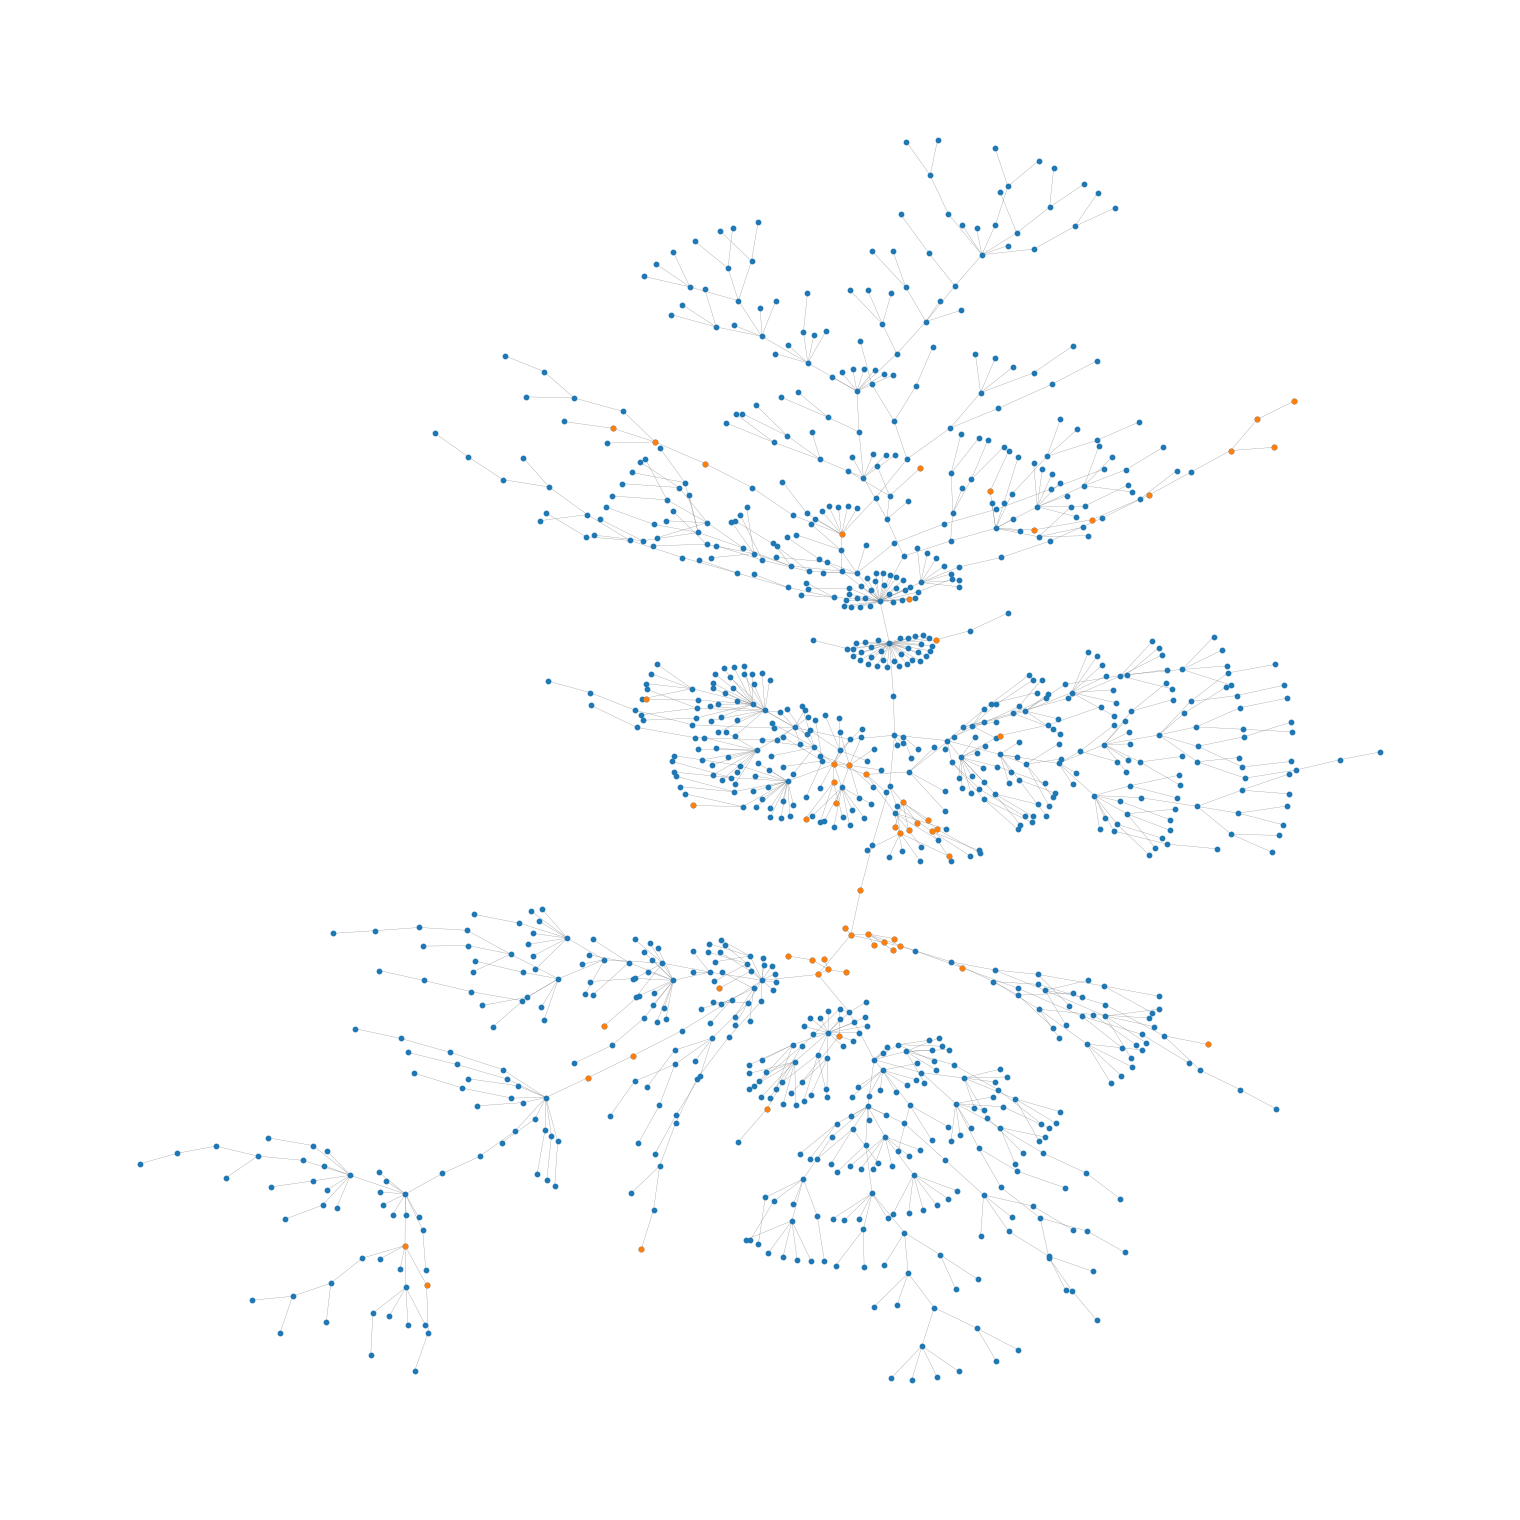

In [175]:
plt.figure(figsize=(15,15))
nx.draw(vasc_graph, pos=layout_pos_full, node_size=10, width=0.2, edge_color='gray')
nx.draw_networkx_nodes(vasc_graph, layout_pos_full, 
                       nodelist=matching_nodes_in_blood_vasc['id'].tolist(), 
                       node_size=10, node_color='tab:orange', )
plt.show()

In [176]:
blood_vasc_edges

,source,target
0,1,2
1,1,14
2,1,668
3,1,1045
4,1,0
...,...,...
4419,1070,1074
4452,1078,1079
4453,1078,1082
4458,1079,1080


In [177]:
layer = blood_vasc_edges[blood_vasc_edges.target.isin(matching_nodes_in_blood_vasc['id'])]
layers = [layer]
indices = list(layer.index)
while len(layer):
    layer = blood_vasc_edges[(blood_vasc_edges.target.isin(layer.source)) & (~blood_vasc_edges.index.isin(indices))]
    layers += [layer]
    indices += list(layer.index)

In [178]:
pruned_vasc_edges = blood_vasc_edges[blood_vasc_edges.index.isin(indices)]

In [179]:
len(pruned_vasc_edges)

115

In [180]:
nodes_of_pruned = blood_vasc_nodes[blood_vasc_nodes['id'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))]['id'].tolist()

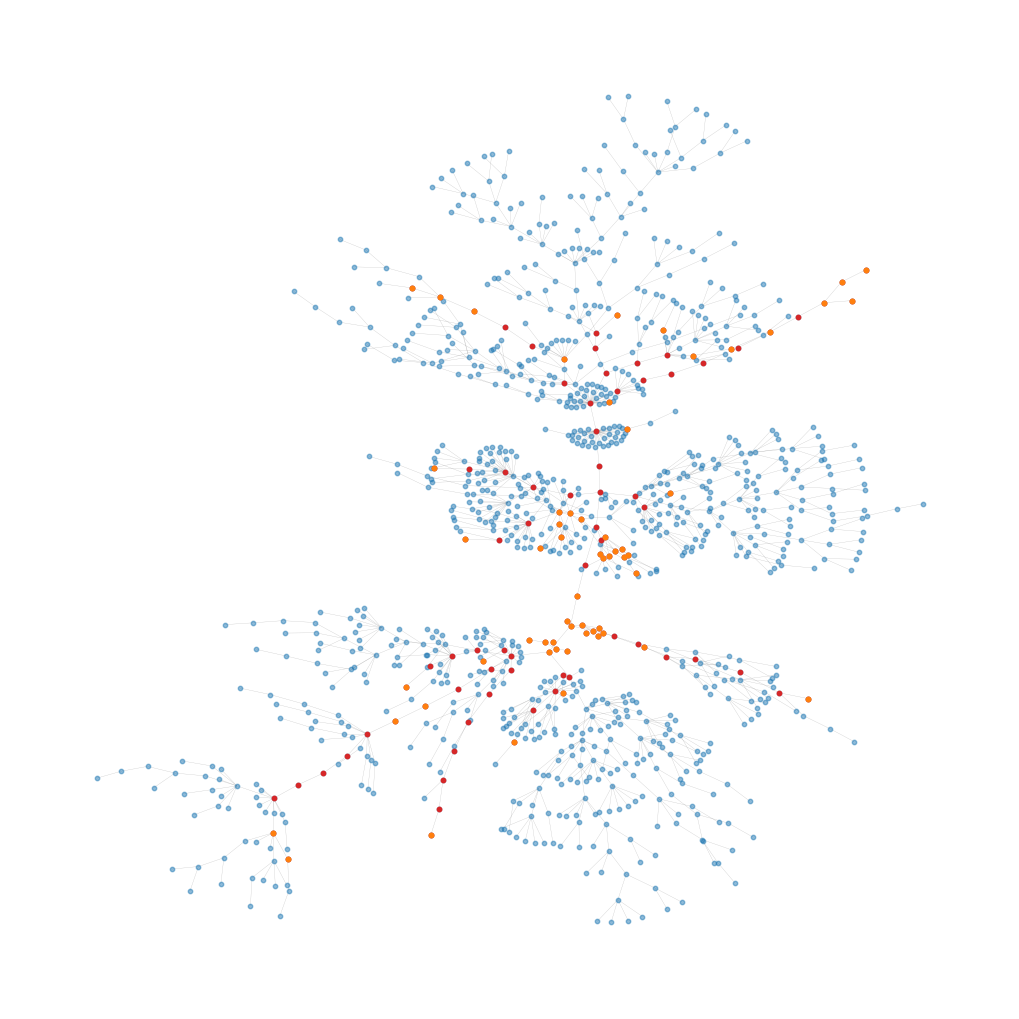

In [181]:
plt.figure(figsize=(10,10))
nx.draw(vasc_graph, pos=layout_pos_full, node_size=10, width=0.2, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(vasc_graph, layout_pos_full, nodelist=nodes_of_pruned, node_size=10, node_color='tab:red')
nx.draw_networkx_nodes(vasc_graph, layout_pos_full, nodelist=matching_nodes_in_blood_vasc['id'].tolist(), node_size=10, node_color='tab:orange')
plt.show()

In [182]:
pruned_vasc_graph = nx.from_pandas_edgelist(pruned_vasc_edges)

In [183]:
len(pruned_vasc_graph)

116

In [184]:
pruned_vasc_graph = nx.induced_subgraph(vasc_graph, set(pruned_vasc_graph.nodes).union(set(matching_nodes_in_blood_vasc['id'].tolist())))

In [185]:
len(pruned_vasc_graph)

116

In [186]:
pruned_vasc_graph_nodes = blood_vasc_nodes[blood_vasc_nodes['id'].isin(set(pruned_vasc_graph.nodes))]

In [187]:
pruned_vasc_graph_nodes


,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
1047,1047,1047,left pulmonary artery,AS,blood_vasculature,UBERON:0001652
1061,1061,1061,segmental pulmonary artery,AS,blood_vasculature,FMA:8755
1062,1062,1062,subsegmental pulmonary artery,AS,blood_vasculature,FMA:9311


### Get the coordinates from the Vega visualization 

In [188]:
with open('viz_v16/female_wing_viz.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [189]:
female_viz = viz['data'][0]['values']

In [190]:
female_viz

[{'id': 0,
  'name': 'Body',
  'type': 'AS',
  'ontology_id': 'UBERON:0013702',
  'color': '#984ea0',
  'organ': 'body',
  'organ_label': '',
  'alpha': 0.5563104897839476,
  'radius': 0,
  'depth': 0,
  'children': 25,
  'angle': 14.009678365431625,
  'radians': 0.2445150146221992,
  'leftside': False,
  'x': 860,
  'y': 860},
 {'id': 1,
  'name': 'Bone marrow',
  'parent': 0,
  'type': 'AS',
  'ontology_id': 'UBERON:0002371',
  'color': '#984ea0',
  'organ': 'bone_marrow',
  'organ_label': 'Bone marrow',
  'alpha': 0.12938703685599764,
  'radius': 66.53846153846153,
  'depth': 1,
  'children': 47,
  'angle': 305.7019258969596,
  'radians': 5.335505136589664,
  'leftside': False,
  'x': 898.829750710468,
  'y': 805.9665166432125},
 {'id': 2,
  'name': 'B lineage',
  'parent': 1,
  'type': 'CT',
  'ontology_id': 'CL:0000945',
  'color': '#ff7f00',
  'organ': 'bone_marrow',
  'organ_label': '',
  'alpha': 0.1203930002932838,
  'radius': 133.07692307692307,
  'depth': 2,
  'children': 0,

In [191]:
pruned_vasc_graph_nodes

,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
1047,1047,1047,left pulmonary artery,AS,blood_vasculature,UBERON:0001652
1061,1061,1061,segmental pulmonary artery,AS,blood_vasculature,FMA:8755
1062,1062,1062,subsegmental pulmonary artery,AS,blood_vasculature,FMA:9311


In [220]:
def get_the_coordinates_for_the_vessels(vizualization_coordinates, graph):
    '''Return the coordinates of the vessels in the visualization in a pandas dataframe'''
    node_ids = []
    ontology_ids = []
    name_of_vessels = []
    organ = []
    coordinates = []
    for node in vizualization_coordinates:
        if node['ontology_id'] in pruned_vasc_graph_nodes.ontology_id.values:
            if node['ontology_id']=='':
                if node['name'] in pruned_vasc_graph_nodes.name.values:
                    node_ids += [node['id']]
                    ontology_ids += ['']
                    name_of_vessels += [node['name']]
                    organ += [node['organ']]    
                    coordinates += [np.array([node['x'], -node['y']])]

            elif node['ontology_id']!='':

                node_ids += [node['id']]
                ontology_ids += [node['ontology_id']]
                name_of_vessels += [node['name']]
                organ += [node['organ']]
                coordinates += [np.array([node['x'], -node['y']])]

        elif node['name'].lower() in pruned_vasc_graph_nodes.name.apply(str.lower).values:
            node_ids += [node['id']]
            ontology_ids += ['ontology_id']
            name_of_vessels += [node['name']]
            organ += [node['organ']]    
            coordinates += [np.array([node['x'], -node['y']])]


    for node in pruned_vasc_graph_nodes.itertuples():
        if node[-1] not in ontology_ids:
            node_ids += [max(node_ids)+1]
            ontology_ids += [node[-1]]
            name_of_vessels += [node[3]]
            organ += [np.nan]
            coordinates += [np.nan]

    return pd.DataFrame({'id': node_ids, 'ontology_id': ontology_ids, 'name': name_of_vessels, 'organ': organ, 'coordinates': coordinates})

In [221]:
coords = get_the_coordinates_for_the_vessels(female_viz, pruned_vasc_graph)

In [222]:
coords

,id,ontology_id,name,organ,coordinates
0,0,UBERON:0013702,Body,body,"[860, -860]"
1,923,UBERON:0005336,Choriocapillaris,eye,"[1131.833540298991, -668.1909857015318]"
2,1181,UBERON:0002078,right atrium,heart,"[982.105217435013, -807.0870211501043]"
3,1183,FMA:3823,sinoatrial nodal artery,heart,"[1041.6303321985274, -777.1946607965374]"
4,1192,UBERON:0035422,left circumflex artery,heart,"[1045.154454608299, -785.4069057227731]"
...,...,...,...,...,...
123,3568,UBERON:0002333,pulmonary trunk,NaN,NaN
124,3569,UBERON:0001652,left pulmonary artery,NaN,NaN
125,3570,FMA:8755,segmental pulmonary artery,NaN,NaN
126,3571,FMA:9311,subsegmental pulmonary artery,NaN,NaN


In [223]:
coords.dropna()

,id,ontology_id,name,organ,coordinates
0,0,UBERON:0013702,Body,body,"[860, -860]"
1,923,UBERON:0005336,Choriocapillaris,eye,"[1131.833540298991, -668.1909857015318]"
2,1181,UBERON:0002078,right atrium,heart,"[982.105217435013, -807.0870211501043]"
3,1183,FMA:3823,sinoatrial nodal artery,heart,"[1041.6303321985274, -777.1946607965374]"
4,1192,UBERON:0035422,left circumflex artery,heart,"[1045.154454608299, -785.4069057227731]"
...,...,...,...,...,...
68,3415,UBERON:0002493,uterine artery,uterus,"[903.9500381272381, -1054.7169636260853]"
69,3418,UBERON:0015173,arcuate artery of uterus,uterus,"[919.9105265225226, -1119.3233476459059]"
70,3421,UBERON:0015173,arcuate artery of uterus,uterus,"[911.8121278634774, -1121.0620103131512]"
71,3424,UBERON:0015173,arcuate artery of uterus,uterus,"[909.2439404695801, -1121.5586055734234]"


In [224]:
len(matching_nodes_in_blood_vasc)

59

In [225]:
nodes_wo_coords = [node for node in coords[coords['coordinates'].isna()]['name'].values if node in matching_nodes_in_blood_vasc['name'].values ]
nodes_wo_coords

['blood vasculature', 'dorsal lingual artery', 'lesser palatine artery']

In [226]:
nodes_wo_coords = [node for node in coords[coords['coordinates'].isna()]['ontology_id'].values if node in matching_nodes_in_blood_vasc['ontology_id'].values ]
nodes_wo_coords

['UBERON:0004537', 'FMA:49546', 'FMA:49796']

In [227]:
matching_nodes_in_blood_vasc[matching_nodes_in_blood_vasc['ontology_id'].isin(nodes_wo_coords)]

,id,id_old,name,type,organ,ontology_id
44,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
10,47,47,dorsal lingual artery,AS,blood_vasculature,FMA:49546
11,59,59,lesser palatine artery,AS,blood_vasculature,FMA:49796


In [228]:
nodes[nodes['ontology_id']=='UBERON:0004537']

,id,id_old,name,type,organ,ontology_id,parent,color
3187,3187,6,vascular system,AS,prostate,UBERON:0004537,3182,#984ea0


In [229]:
nodes[nodes['ontology_id']=='FMA:49546']

,id,id_old,name,type,organ,ontology_id,parent,color


In [240]:
nodes[nodes['name']=='dorsal lingual artery']

,id,id_old,name,type,organ,ontology_id,parent,color
3222,3222,8,dorsal lingual artery,AS,palatine_tonsil,UBERON:0001610,3221,#984ea0


In [237]:
nodes[nodes['name']=='lesser palatine artery']

,id,id_old,name,type,organ,ontology_id,parent,color
3226,3226,12,lesser palatine artery,AS,palatine_tonsil,UBERON:0001070,3221,#984ea0


In [231]:
nodes[nodes['id']==3221]

,id,id_old,name,type,organ,ontology_id,parent,color
3221,3221,7,blood vessel,AS,palatine_tonsil,UBERON:0001981,3215,#984ea0


In [243]:
blood_vasc_nodes[blood_vasc_nodes['ontology_id']=='']

,id,id_old,name,type,organ,ontology_id
id,,,,,,
8,8,8,pulmonary venule,AS,blood_vasculature,
9,9,9,bronchial capillary #2,AS,blood_vasculature,
10,10,10,intra-acinar venule,AS,blood_vasculature,
11,11,11,post-alveolar capillary,AS,blood_vasculature,
25,25,25,neuromeningeal trunk,AS,blood_vasculature,
...,...,...,...,...,...,...
1057,1057,1057,lingular artery of left lung,AS,blood_vasculature,
1064,1064,1064,intra-acinar arteriole,AS,blood_vasculature,
1065,1065,1065,pre-alveolar capillary,AS,blood_vasculature,


In [246]:
nodes[nodes['ontology_id']=='']['organ'].value_counts()

organ
ovary                 83
fallopian_tube        68
uterus                65
small_intestine       62
spleen                31
brain                 17
palatine_tonsil       14
ureter                12
eye                   12
urinary_bladder       11
placenta_full_term    10
knee                   9
large_intestine        5
kidney                 4
liver                  3
pancreas               3
prostate               1
heart                  1
Name: count, dtype: int64

In [234]:
[item for item in female_viz if 'dorsal lingual artery' in item['name']]

[{'id': 3189,
  'name': 'dorsal lingual artery',
  'parent': 3188,
  'type': 'AS',
  'ontology_id': 'UBERON:0001610',
  'color': '#984ea0',
  'organ': 'palatine_tonsil',
  'organ_label': '',
  'alpha': 0.9085932153680711,
  'radius': 199.61538461538458,
  'depth': 3,
  'children': 1,
  'angle': 70.3749144588914,
  'radians': 1.2282739681170185,
  'leftside': False,
  'x': 927.0436203727446,
  'y': 1048.0198253973851}]

In [239]:
coords[coords['name']=='blood vasculature']

,id,ontology_id,name,organ,coordinates
73,3518,UBERON:0004537,blood vasculature,NaN,NaN
